In [1]:
#@title Imports 
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import tjy_udf as tjy
print("tjy_udf: ", list(filter(lambda x: '__' not in x, dir(tjy)))) # Print contained functions
mpl.rc_file('tjy.mplstyle')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
DISPLAY_SORTED = True
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import animation, rc
    
GIT = 'https://github.com/tyokokur/tmpdat/raw/main/int/'

###COOLWARM COLORMAP DOCUMENTATION  
#https://depts.washington.edu/airqual/coolwarm.m
#Base blue: RGB = [59 76 192]
#Base red:  RGB = [180 4 38]
warm_red = [180/255, 4/255, 38/255]
cool_blue = [59/255,76/255,192/255]
mix_purp = np.divide(np.add(warm_red,cool_blue),2).tolist()

tjy_udf:  ['H_find', 'Kap_D', 'git_sync', 'lighten_color', 'plot_anim', 'plot_pha', 'ticks']


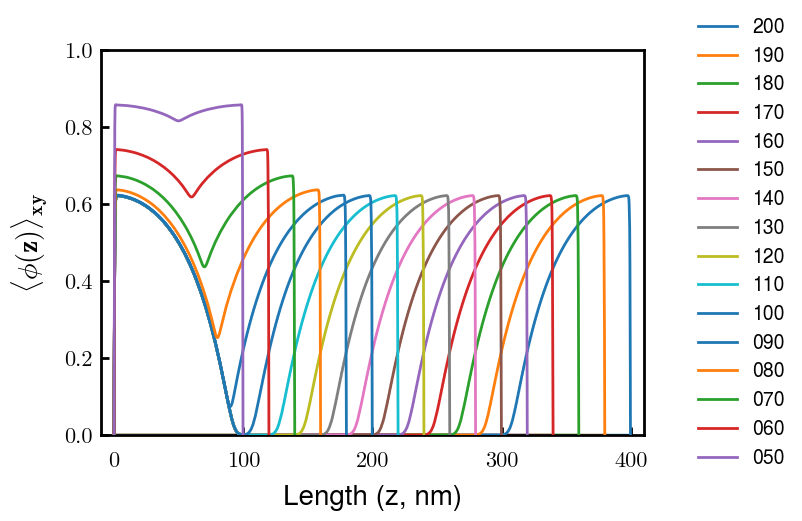

In [2]:
labs = ['{:03d}'.format(i) for i in np.arange(200, 49, -10)]
read_list = [GIT+'ph_a050d{}.dat'.format(i) for i in labs]
max_d = 200
# shifts = [max_d-float(i) for i in labs]
shifts = [0 for i in labs]
fig, ax = tjy.plot_pha(read_list, b0=1.0, x1_start = -10, x1_end=max_d*2+10, labs=labs, double=False, show=False)
plt.sca(ax)
# plt.plot([200]*2,[0,1], '--', lw =2, color='k')
plt.legend(frameon=True, framealpha=1.0, facecolor='w', edgecolor='w', loc='center left', bbox_to_anchor=(1.05,0.5))
plt.show()

0    50.0
1    60.0
2    70.0
3    80.0
4    90.0
Name: lx, dtype: float64

0     110.0
1     130.0
2     150.0
3     170.0
4     190.0
5     210.0
6     230.0
7     250.0
8     270.0
9     290.0
10    310.0
11    330.0
12    350.0
13    370.0
14    390.0
Name: lx, dtype: float64

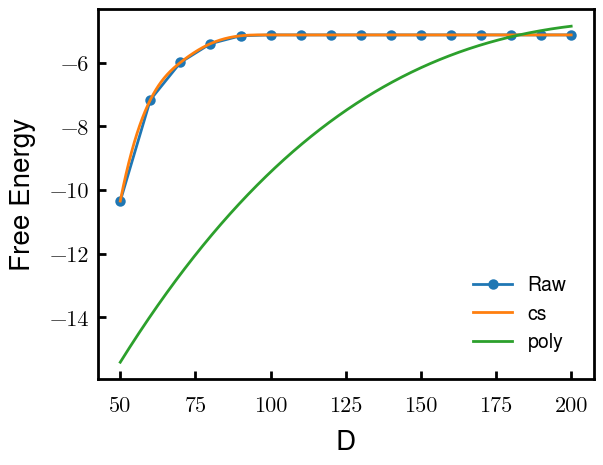

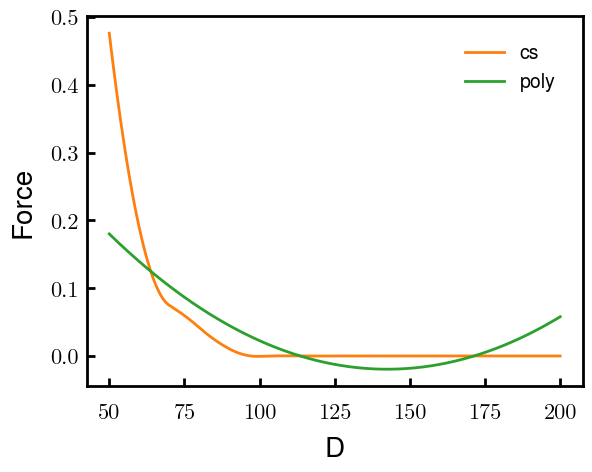

In [160]:
from scipy.interpolate import CubicSpline
import numpy.polynomial.polynomial as poly
freeE = pd.read_csv(GIT+'coll100.txt', sep="\s+", skiprows=0, names = ['it', 'lx', 'freeE', 'freeDiff', 'inCompMax', 'andErr']).sort_values(by='lx', ignore_index=True)
d, y = freeE.lx/2, freeE.freeE
display(d.head())
dxc = d.iloc[:-1]+d.iloc[1:].reset_index(drop=True)
display(dxc)

d_new = np.linspace(50, 200, 1000)
f = CubicSpline(d, y, bc_type=('not-a-knot', (1, 0)))
csfit = f(d_new)
csder = CubicSpline.derivative(f)(d_new)
coefs = poly.polyfit(d, y, 3)
polyfit = poly.polyval(d_new, coefs)
polydercoefs = poly.polyder(coefs)
polyder = poly.polyval(d_new, polydercoefs)

plt.figure()
plt.plot(d, y, 'o-', label='Raw')
plt.plot(d_new, csfit, 'C1', label='cs')
plt.plot(d_new, ffit, 'C2', label='poly')

plt.xlabel('D')
plt.ylabel('Free Energy')
plt.legend()
tjy.ticks()
plt.show()

plt.figure()
plt.plot(d_new, csder, 'C1', label='cs')
plt.plot(d_new, polyder, 'C2', label='poly')

plt.xlabel('D')
plt.ylabel('Force')
plt.legend()
tjy.ticks()
plt.show()

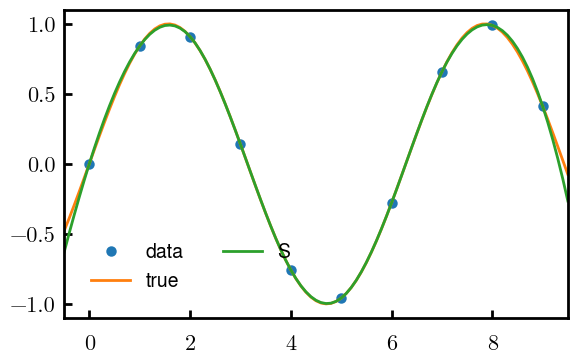

In [21]:
x = np.arange(10)
y = np.sin(x)
cs = CubicSpline(x, y)
xs = np.arange(-0.5, 9.6, 0.1)
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(x, y, 'o', label='data')
ax.plot(xs, np.sin(xs), label='true')
ax.plot(xs, cs(xs), label="S")
ax.set_xlim(-0.5, 9.5)
ax.legend(loc='lower left', ncol=2)
tjy.ticks()
plt.show()